### Architecture - semantic search

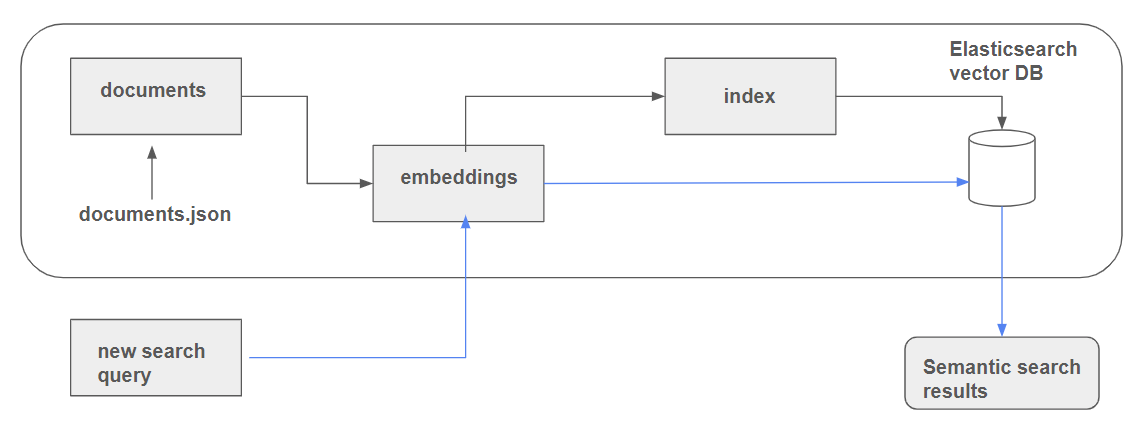

## Step 1: Prepare documents

In [1]:
import requests

In [2]:
# load json data directly from the url 
docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url, timeout=10)
documents_raw = docs_response.json()

In [3]:
# rearrange data a bit (add course type to each faq) LLMS likes data in the same level
documents = []
for course_dict in documents_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course'] #adding it to every faq
        documents.append(doc)


In [4]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

## Step 2: Create embeddings using pretrained models

In [6]:
from sentence_transformers import SentenceTransformer

In [7]:
# import a pretrained model
# background:
# It maps sentences & paragraphs to a 768 dimensional dense vector space
# can be used for tasks like clustering or semantic search.
# The model is based on the MPNet (Masked and Permuted Pre-training) architecture, 
# which is a transformer model developed by Microsoft.  
model = SentenceTransformer("all-mpnet-base-v2")

/Users/andreanicolas/anaconda3/envs/llm_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
#check out how big of a vector this model generates
len(model.encode("this is a simple sentence and i like kitties"))

768

In [12]:
# convert documents to a bunch of vectors (dense vector)
operations = []
for doc in documents:
    # transform the texts (actual answers) into vectors
    doc['text_vector'] = model.encode(doc['text']).tolist()
    operations.append(doc)

## Step 3: Setup the elasticsearch connection

In [13]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200')

es_client.info()

ObjectApiResponse({'name': '3fc038297211', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'nghpXDx2SviBiAZcYHPc7Q', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

## Step 4: Create mappings and index

what is different this time is that we are giving the mapping properties to the new `text_vector` field.
You need to speficy:
- the fact that it is a dense vector
- dimensions (you found them on the prior sections)
- the similarity metric. Popular ones are cosine and dot product ones.

In [14]:
# set up mapping
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "text_vector": {"type":"dense_vector","dims":768,"index":True,"similarity":"cosine"}
        }
    }
}


In [15]:

index_name = 'course-questions'

#best practice :
# sometimes we have newer data or we fixed something, and we remake index
# just delete the index if it already exists, if does not exist just ignore
es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

## Step 5: add documents to the index

In [16]:
for doc in operations:
    try:
        es_client.index(index=index_name,document=doc)
    except Exception as e:
        print(e)

## Step 6: add a new user query
Indexing is done, we have done all the stuff in the black-arrowed flowchart.
We try now the blue arrows

In [17]:
# convert a question to vector
search_term = 'windows or mac?'
vector_search_term = model.encode(search_term)

In [19]:
# create the proper query
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5, #get me 5 nearest neighbors matching this search term
    "num_candidates": 10000, #group of documents that search will look into
}

In [20]:
# actually search
#source means that those are the fields that you want back
res = es_client.search(index=index_name,knn=query,source=["text","section","question","course"])
res["hits"]["hits"]

# the results are ranked by a score, and presented in a descending order.
# Best score is 1, worst is 0.

[{'_index': 'course-questions',
  '_id': '5ICa_pEBuiDAaMLTnsT0',
  '_score': 0.71479195,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': '94Ca_pEBuiDAaMLTrseE',
  '_score': 0.6134736,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares a

Sematic search was smart enought to understand the underlying meanings, so it got that the question is asking about operating systems, and therefore it found the good answers related to that.
This is how google actually figures out the context.

## Step 7: Perform keyword search and advanced search

In [24]:
# create properly formatted search query that works with elasticsearch
search_query = {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": search_term, # we are passing keywords actually
                        "fields": ["text", "question", "course", "title "], # we will retrieve all 4
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp" # we filter by course name
                    }
                }
            }
}

# search for it
response = es_client.search(index=index_name,query=search_query)


# Step 7b: Do semantic searchy passing the vector embedding

In [25]:
# create the proper query settings
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5, #get me 5 nearest neighbors matching this search term
    "num_candidates": 10000, #group of documents that search will look into
}

# search properly using semantic search
response = es_client.search(
    index=index_name,
    query={"match": {"course": "data-engineering-zoomcamp"}}, # we are searching only on dataeng
    knn=knn_query, # actual query as vector input
    size=5
    )



In [27]:
# note that the results' scores have values greater than one.
# Anytime you do advanced functionalities, scales get odd.
# you can validate results,
# you can also set explain=True to see how scores got calculated
# You can always override the scores and calculate one that makes more sense to your data
response['hits']['hits']

[{'_index': 'course-questions',
  '_id': '5ICa_pEBuiDAaMLTnsT0',
  '_score': 1.493706,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965396478772163,
    -0.0006259590154513717,
    -0.016629520803689957,
    0.05285145714879036,
    0.05476526916027069,
    -0.031339775770902634,
    0.029942533001303673,
    -0.048085663467645645,
    0.04467548802495003,
    0.005839454010128975,
    0.016233166679739952,
    0.01200114469975233,
    -0.031222375109791756,
    0.01660064235329628,
    -0.04886898025870323,
    -0.06496303528547287,
    0.046434249728918076,
    -0.009297626093029976,
    -0.06425279378890991,
    -0.013732705265283585,
    -0.01597617380321026,
    0.008629579097032547,
    -0.024479009211